# Finetune Masked-AutoEncoder

- Finetune the deep network after pretraining the self-supervised learning framework.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

/home/imkbsz/workspace/eeg_analysis


In [2]:
# Load some packages
import os
import gc
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
import wandb
import pprint
import numpy as np
import torch
from tqdm.auto import tqdm
from collections import OrderedDict
from cycler import cycler

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

# custom package
from run_train import check_device_env
from run_train import set_seed
from run_train import compose_dataset
from run_train import generate_model
from train.ssl_train_script import ssl_train_script
from train.train_script import train_script
from models.utils import count_parameters

---

## Specify the dataset, model, and train setting

In [3]:
pre_model_path = 'local/checkpoint/'
pre_model_name = 'vt7lwk2m'
device = 'cuda:3'
ddp_size = 1

############
# Artifact #
############
art_config = dict()
art_config['project'] = 'tuab-mae-artifact'
art_config['use_wandb'] = False
art_config['pre_model'] = pre_model_name
art_config['device'] = device
art_config['ddp_size'] = ddp_size

# art_config["art_filter_list"] = [9, 9, 9, 9, 9]
art_config["art_dropout"] = 0.1
art_config["art_use_age"] = "no"  # "conv", "embedding", "no"

art_config['total_samples'] = 5.0e+6
art_config['search_lr'] = False
art_config['base_lr'] = 1e-3
art_config['lr_scheduler_type'] = 'cosine_decay_with_warmup_half'

art_config["warmup_min"] = 150
art_config["num_history"] = 50
art_config['save_model'] = False

##################
# Classification #
##################
finetune_config = dict()
finetune_config['project'] = 'tuab-mae-artifact-finetune'
finetune_config['use_wandb'] = True
finetune_config['pre_model'] = pre_model_name
finetune_config['device'] = device
finetune_config['ddp_size'] = ddp_size
finetune_config["task"] = "tuab"
finetune_config["out_dims"] = 3

# finetune_config["mask_ratio"] = 0.25
finetune_config["descending"] = False  #######################################################
finetune_config["global_pool"] = True
finetune_config["fc_stages"] = 3
finetune_config["dropout"] = 0.1
# finetune_config["use_age"] = "fc"
# finetune_config["mixup"] = 0.3 ###
# finetune_config["crop_length"] = 8192*4  #############################################################
# finetune_config["criterion"] = "multi-bce"  # "cross-entropy", "multi-bce"

finetune_config["tuning_type"] = "finetune"  # "finetune", "fc_stage"
finetune_config["layer_wise_lr"] = True

finetune_config['total_samples'] = 2.0e+6
# finetune_config['base_lr'] = 1e-3
finetune_config['search_lr'] = True
finetune_config['lr_search_steps'] = 100
finetune_config['lr_scheduler_type'] = 'cosine_decay_with_warmup_half'
finetune_config["warmup_min"] = 200
finetune_config["num_history"] = 50
finetune_config['save_model'] = True

In [4]:
finetune_cycler = cycler(mask_ratio=[0.3])
finetune_cycler *= cycler(crop_length=[2560*2]) + cycler(minibatch=[256])
finetune_cycler *= cycler(mixup=[0.1])
finetune_cycler *= cycler(seed=[1000, 1011])
finetune_cycler *= cycler(descending=[False])
for cyc in finetune_cycler:
    print(cyc)

{'mask_ratio': 0.3, 'crop_length': 5120, 'minibatch': 256, 'mixup': 0.1, 'seed': 1000, 'descending': False}
{'mask_ratio': 0.3, 'crop_length': 5120, 'minibatch': 256, 'mixup': 0.1, 'seed': 1011, 'descending': False}


In [5]:
print('PyTorch version:', torch.__version__)
device = torch.device(device if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 2.0.1
cuda is available.


---
## Uncertainty Pretraining

In [6]:
# load pretrained configurations
path = os.path.join(pre_model_path, pre_model_name.split(',')[-1], 'checkpoint.pt')
try:
    ckpt = torch.load(path, map_location="cpu")
    config = ckpt['config']
except Exception as e:
    print(e)
    print(f'- checkpoint cannot be opened: {path}')
config["cwd"] = ""

pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d.mae_1d_pre_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([0.]),
 'age_std': tensor([0.]),
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 32,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'tuab',
 'dataset_path': 'local/dataset/tuab/',
 'ddp': True,
 'ddp_size': 4,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 24,
 'input_norm': 'datapoint',
 'iterations': 48828,
 'latency': 2500,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'mask_ratio': 0.75,
 'mgn': 0.003,
 'minibatch': 512,
 'minibatch_3090': 256,
 'mixed_precision': True,
 'mixup': 0.0,
 'model': '1D-MAE-B',
 'multi_batch_size': 64,
 'norm_pix_loss': True,
 'num_history': 500,
 'num_params': 123772800,
 'num_workers

In [7]:
# update configuration
for k, v in art_config.items():
    config[k] = v

In [8]:
# load pretrained model
if not config.get("ddp", False):
    pre_model_state = ckpt["ssl_model_state"]
else:
    pre_model_state_ddp = deepcopy(ckpt["ssl_model_state"])
    pre_model_state = OrderedDict()
    for k, v in pre_model_state_ddp.items():
        name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
        pre_model_state[name] = v

In [9]:
config["ddp"] = False

# check the workstation environment and update some configurations
check_device_env(config)

# compose dataset
train_loader, val_loader, test_loader, multicrop_test_loader = compose_dataset(config)

pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d.mae_1d_pre_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([0.]),
 'age_std': tensor([0.]),
 'art_dropout': 0.1,
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 32,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'tuab',
 'dataset_path': 'local/dataset/tuab/',
 'ddp': False,
 'ddp_size': 1,
 'device': device(type='cuda', index=3),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 24,
 'input_norm': 'datapoint',
 'iterations': 48828,
 'latency': 2500,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'mask_ratio': 0.75,
 'mgn': 0.003,
 'minibatch': 512,
 'minibatch_3090': 256,
 'mixed_precision': True,
 'mixup': 0.0,
 'model': '1D-MAE-B',
 'multi_batch_size': 64,
 'norm_pix_loss': True,
 'num_history': 

In [10]:
# generate the model
config["_target_"] = config["_target_"].replace('pre', 'pre_art').replace('.mae_1d.', '.mae_1d_artifact.')
model = generate_model(config).to(device)

# load the model
model_state = model.state_dict()
for k, v in model_state.items():
    if not k.startswith('art') and not k.endswith("pos_embed"):
        model_state[k] = pre_model_state[k]

pre_model_state = deepcopy(model.state_dict())
model.load_state_dict(model_state)

<All keys matched successfully>

In [11]:
model.requires_grad_(False)
model = model.eval()

model.art_net.requires_grad_(True)
for k, v in model._parameters.items():
    if k.startswith("art"):
        v.requires_grad_(True)
model.art_net = model.art_net.train()

config["num_params"] = count_parameters(model)

# print(model)

In [12]:
for name, param in model.named_parameters():
    print(f"{name:100}\t|\t{param.requires_grad}")

class_token                                                                                         	|	False
enc_pos_embed                                                                                       	|	False
mask_token                                                                                          	|	False
dec_pos_embed                                                                                       	|	False
enc_proj.weight                                                                                     	|	False
enc_proj.bias                                                                                       	|	False
enc_blocks.encoder_layer_0.norm1.weight                                                             	|	False
enc_blocks.encoder_layer_0.norm1.bias                                                               	|	False
enc_blocks.encoder_layer_0.self_attention.in_proj_weight                                            	|	False
enc_blocks.encoder_

In [13]:
# collect some garbage
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

# fix the seed for reproducibility (a negative seed value means not fixing)
set_seed(config, rank=None)

# train
ssl_train_script(
    config,
    model,
    train_loader,
    config["preprocess_train"],
)

for k, v in model_state.items():
    pre_model_state[k] = model_state[k].to("cpu")


******************************    Configurations for Train    ******************************

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d_artifact.mae_1d_pre_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([0.]),
 'age_std': tensor([0.]),
 'art_dropout': 0.1,
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 32,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'tuab',
 'dataset_path': 'local/dataset/tuab/',
 'ddp': False,
 'ddp_size': 1,
 'device': device(type='cuda', index=3),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 24,
 'input_norm': 'datapoint',
 'iterations': 48828,
 'latency': 2500,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'mask_ratio': 0.75,
 'mgn': 0.003,
 'minibatch': 512,
 'minibatch_3090': 256,
 'mixed_precision': 

/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



     195 /     9766 iter - Loss: 0.3004
     390 /     9766 iter - Loss: 0.0810
     585 /     9766 iter - Loss: 0.0576
     780 /     9766 iter - Loss: 0.0507
     975 /     9766 iter - Loss: 0.0476
    1170 /     9766 iter - Loss: 0.0454
    1365 /     9766 iter - Loss: 0.0442
    1560 /     9766 iter - Loss: 0.0432
    1755 /     9766 iter - Loss: 0.0428
    1950 /     9766 iter - Loss: 0.0421
    2145 /     9766 iter - Loss: 0.0416
    2340 /     9766 iter - Loss: 0.0415
    2535 /     9766 iter - Loss: 0.0411
    2730 /     9766 iter - Loss: 0.0403
    2925 /     9766 iter - Loss: 0.0403
    3120 /     9766 iter - Loss: 0.0395
    3315 /     9766 iter - Loss: 0.0395
    3510 /     9766 iter - Loss: 0.0393
    3705 /     9766 iter - Loss: 0.0394
    3900 /     9766 iter - Loss: 0.0394
    4095 /     9766 iter - Loss: 0.0388
    4290 /     9766 iter - Loss: 0.0391
    4485 /     9766 iter - Loss: 0.0389
    4680 /     9766 iter - Loss: 0.0384
    4875 /     9766 iter - Loss: 0.0386


---
## Visualize

In [14]:
signal_header = [channel.split('-')[0] for i, channel in enumerate(config["signal_header"])]
fps = config.get('resample', 200)

In [15]:
@plt.style.context(['ieee', 'science', 'default'])
def draw_eeg_graph(x, pred, mask, art_out, rec_loss, num=None):
    plt.rcParams.update({'font.family': 'Ubuntu'})
    N, C, L = x.shape
    _, l = mask.shape
    patch_size = L // l

    art_out = art_out.reshape(N, -1)
    rec_loss = rec_loss.reshape(N, -1)

    for n in range(N):
        if num is not None and num <= n:
            break
        
        fig = plt.figure(num=1, clear=True, figsize=(25.0, 17.0))
        fig.subplots_adjust(hspace=0)
        
        for c in range(C):
            ax = fig.add_subplot(C, 1, c + 1)
            ax.plot(x[n, c].cpu().numpy(), lw=1, c='tab:red', label='origin')
            ax.plot(pred[n, c].cpu().numpy(), lw=1, c='tab:blue', label='pred')

            art_mid = art_out[n].median()
            rec_mid = art_out[n].median()
            for r in range(l):
                if r > 0:
                    ax.axvline(r*patch_size, color='tab:purple', alpha=0.4)
                if mask[n, r]:
                    ax.axvspan(r*patch_size, (r + 1)*patch_size, facecolor='tab:purple', alpha=0.2)

                if c == 0:
                    if art_mid <= art_out[n, r]:
                        ax.annotate(f"{art_out[n, r]:3.2f}", 
                                    xy=((r + 0.5)*patch_size, 1), ha='center', va='bottom', color='tab:purple')
                    else:
                        ax.annotate(f"{art_out[n, r]:3.2f}", 
                                    xy=((r + 0.5)*patch_size, 1), ha='center', va='bottom')
                    if rec_mid <= rec_loss[n, r]:
                        ax.annotate(f"{rec_loss[n, r]:3.2f}", 
                                    xy=((r + 0.5)*patch_size, -1), ha='center', va='bottom', color='tab:purple')
                    else:
                        ax.annotate(f"{rec_loss[n, r]:3.2f}", 
                                    xy=((r + 0.5)*patch_size, -1), ha='center', va='bottom')

            ax.set_xlim(0, L)
            ax.set_ylabel(signal_header[c])
            ax.set_xticks(np.arange(round(config["seq_length"] / fps) + 1) * fps)
            ax.set_xticklabels([])
            # ax.tick_params(axis='x', width=0.1, length=0.1)
            ax.set_yticks([0])
            ax.set_yticklabels([])
        
        ax.set_xticks(np.arange(round(config["seq_length"] / fps) + 1) * fps)
        ax.set_xticklabels(np.arange(round(config["seq_length"] / fps) + 1))
        
        ax.set_xlabel('Time (s)')
        # fig.savefig(os.path.join(output_folder, 'signal_example.pdf'), transparent=True)
        plt.show()
        fig.clear()
        plt.close(fig)

Dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/12 [00:01<?, ?it/s]

val


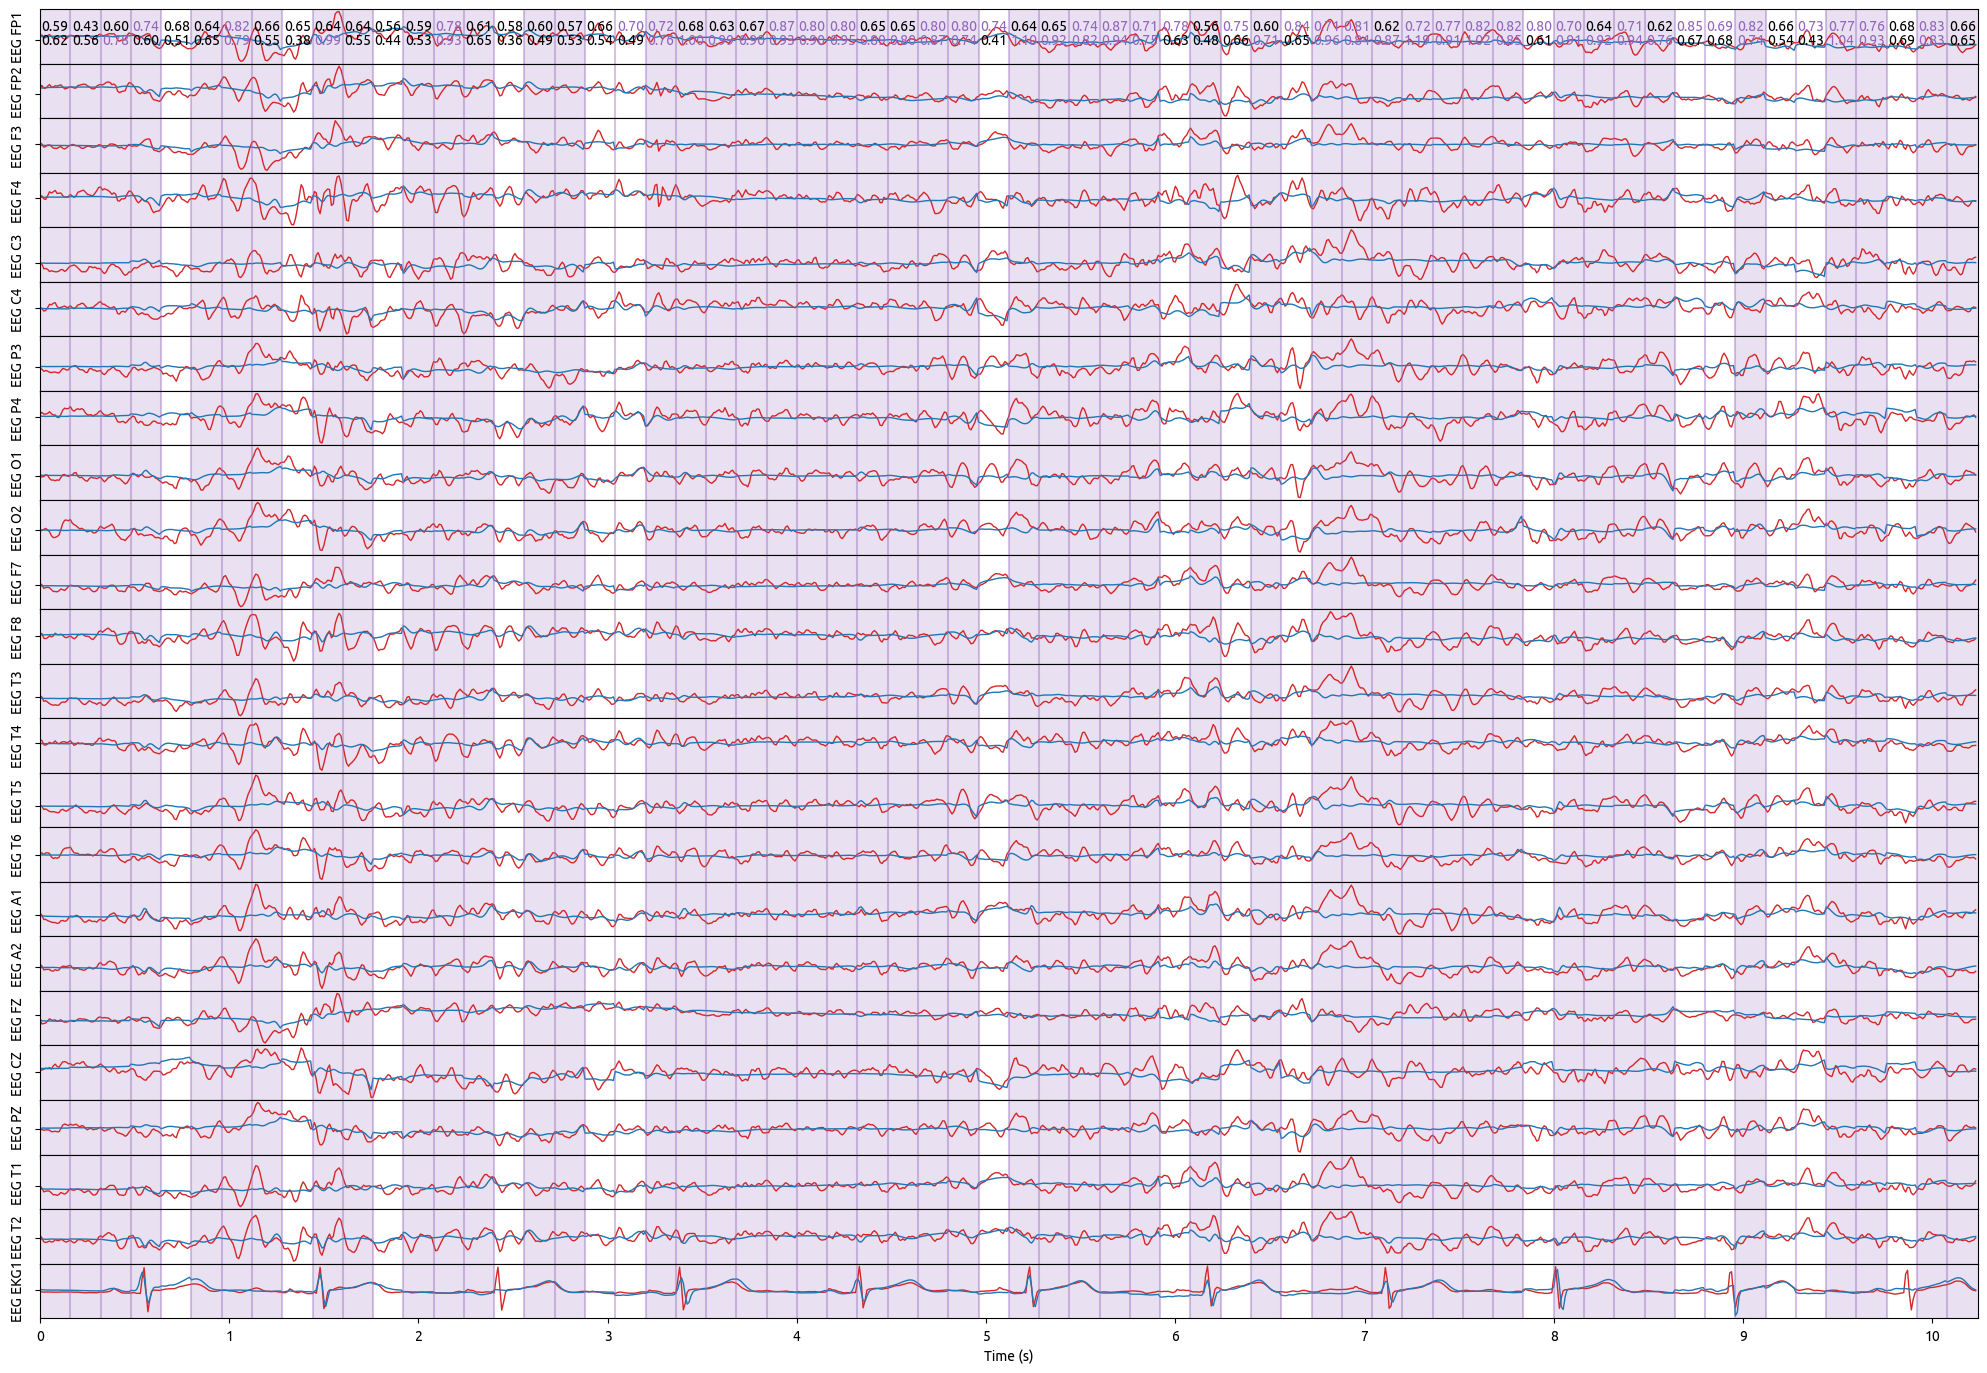

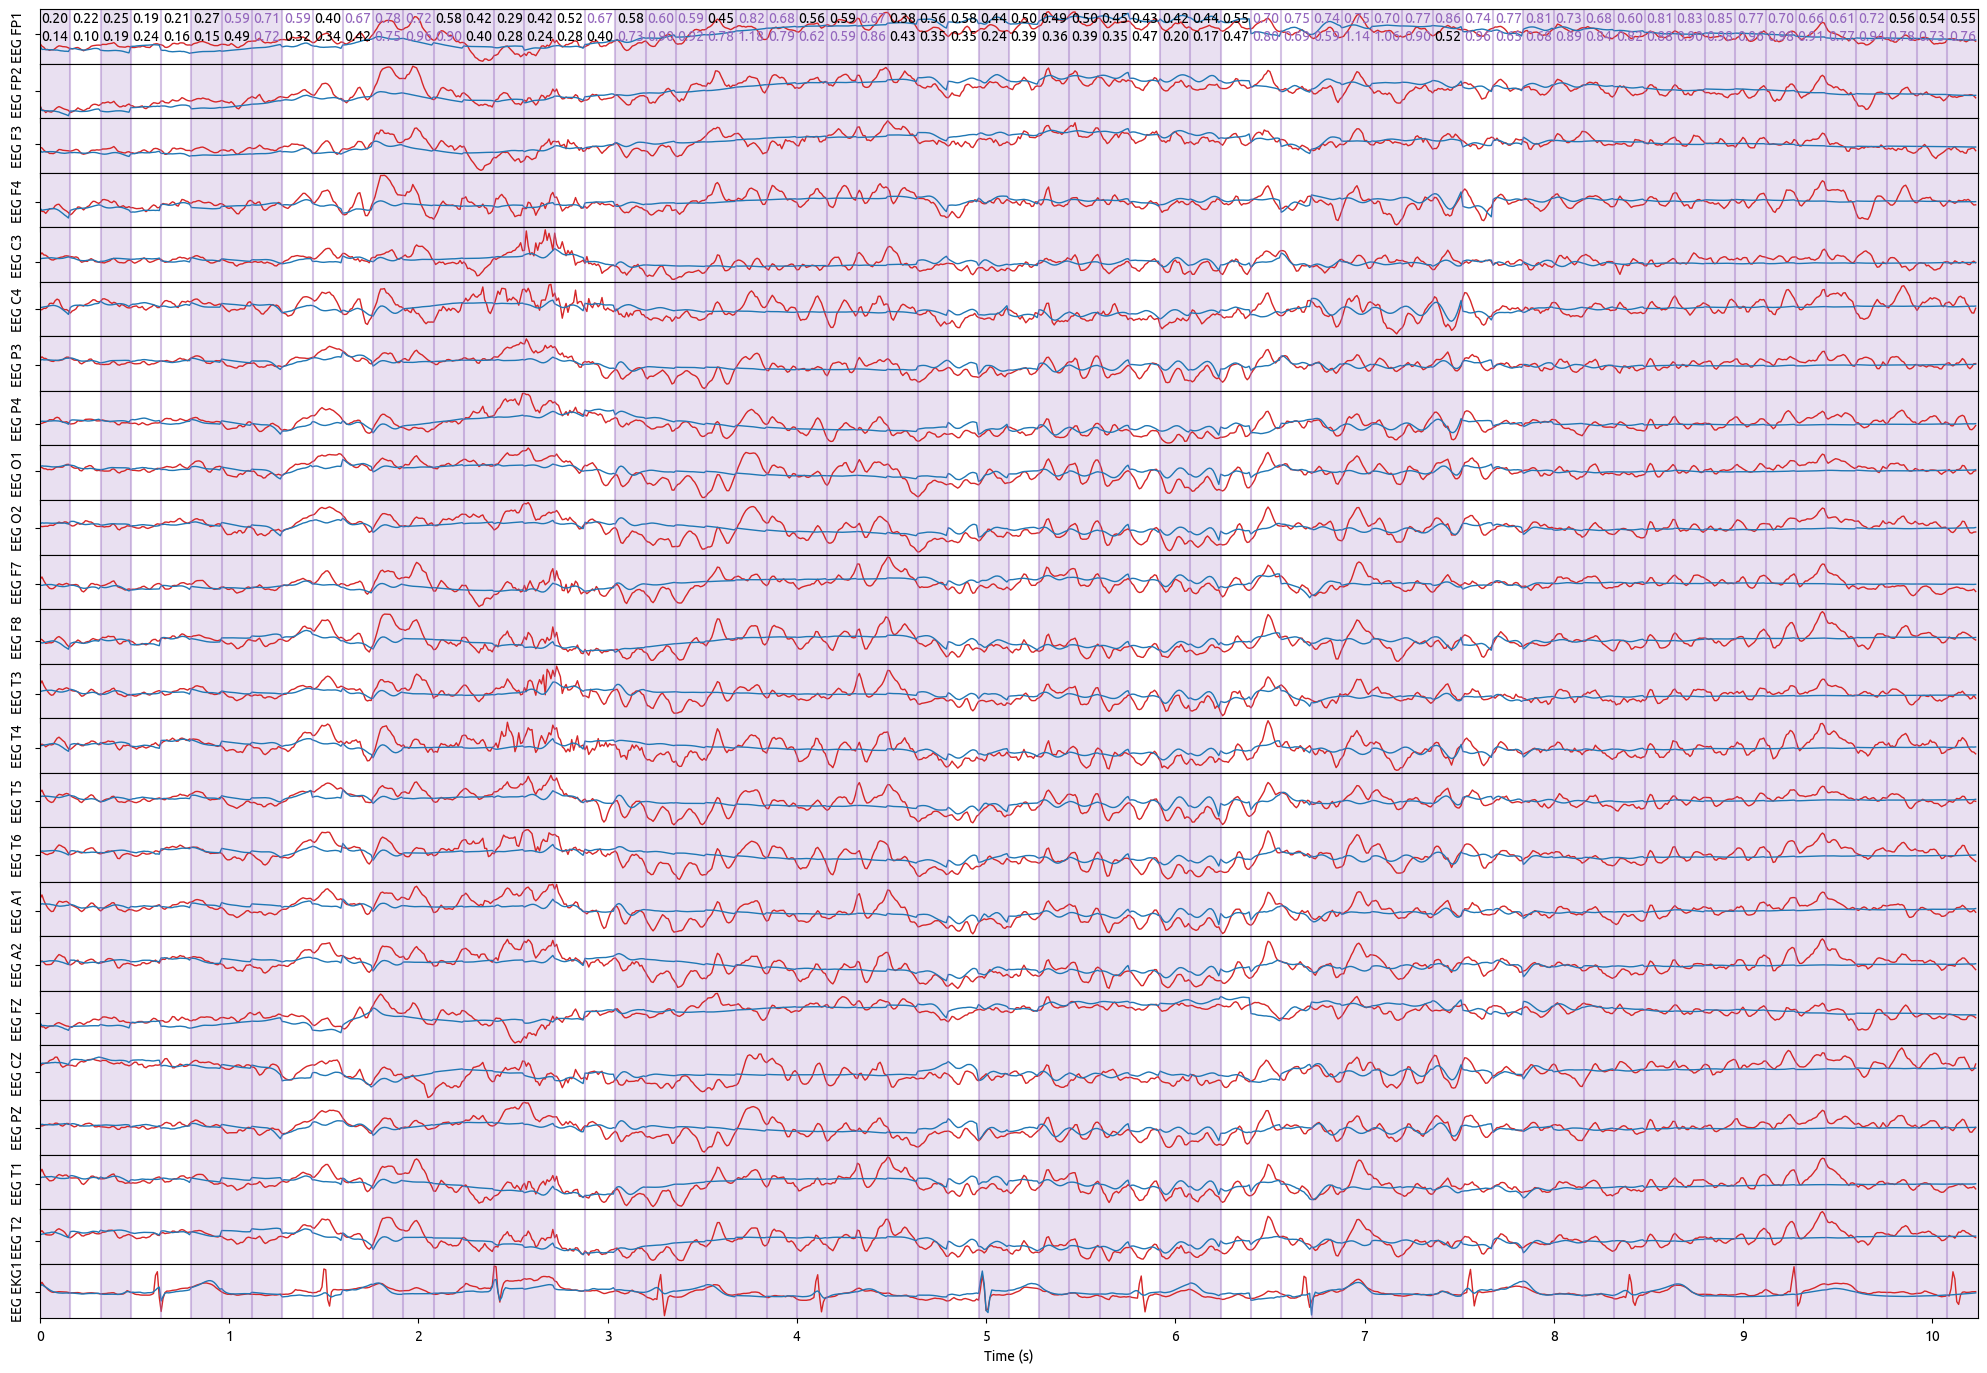

In [16]:
with torch.no_grad():
    for target_dataset in tqdm(["val"], desc="Dataset", leave=False):
        if target_dataset == 'train':
            loader = train_loader
        elif target_dataset == 'val':
            loader = val_loader
        elif target_dataset == 'test':
            loader = test_loader
        else:
            raise ValueError('')
                
        for sample_batched in tqdm(loader, total=len(loader), desc='Batch', leave=False):
            print(target_dataset)
            config["preprocess_test"](sample_batched)
            x = sample_batched["signal"]
            age = sample_batched["age"]

            pred, mask = model.mask_and_reconstruct(x, age, config["mask_ratio"])
            rec_loss = model.compute_reconstruction_loss2(x, pred)
            art_out = model.forward_artifact(x, age)
            
            pred_eeg = model.unpatchify(pred)
            draw_eeg_graph(x, pred_eeg, mask, art_out, rec_loss, 2)

            break
        break

In [17]:
x[0, :2, :30]
print(sample_batched["serial"][0])

00009813_s010_t000.dat


In [18]:
del model, ckpt

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f80fb4d9a60>
Traceback (most recent call last):
  File "/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


---
## Finetuning

In [19]:
for cyc in finetune_cycler:
    # update configuration
    for k, v in finetune_config.items():
        config[k] = v
    for k, v in cyc.items():
        config[k] = v
    config["ddp"] = False

    # check the workstation environment and update some configurations
    check_device_env(config)
    
    # compose dataset
    train_loader, val_loader, test_loader, multicrop_test_loader = compose_dataset(config)
    pprint.pprint(config)

    # generate the model
    config["_target_"] = config["_target_"].replace('.ssl', '').replace('_pre', '')
    model = generate_model(config).to(device)
    
    # load the model
    model_state = model.state_dict()
    for k, v in model_state.items():
        if not k.startswith("fc") and not k.endswith("pos_embed"):
            model_state[k] = pre_model_state[k]
    
    model.load_state_dict(model_state)
    model.finetune_mode(config["tuning_type"])
    config["num_params"] = count_parameters(model)
    
    for name, param in model.named_parameters():
        print(f"{name:100}\t|\t{param.requires_grad}")

    # collect some garbage
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # fix the seed for reproducibility (a negative seed value means not fixing)
    set_seed(config, rank=None)
    
    # train
    train_script(
        config,
        model,
        train_loader,
        val_loader,
        test_loader,
        multicrop_test_loader,
        config["preprocess_train"],
        config["preprocess_test"],
    )

print("- END -")

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d_artifact.mae_1d_pre_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([0.]),
 'age_std': tensor([0.]),
 'art_dropout': 0.1,
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 5120,
 'crop_multiple': 32,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'tuab',
 'dataset_path': 'local/dataset/tuab/',
 'ddp': False,
 'ddp_size': 1,
 'descending': False,
 'device': device(type='cuda', index=3),
 'draw_result': True,
 'dropout': 0.1,
 'fc_stages': 3,
 'file_format': 'memmap',
 'global_pool': True,
 'in_channels': 24,
 'input_norm': 'datapoint',
 'iterations': 9766,
 'latency': 2500,
 'layer_wise_lr': True,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'lr_search_steps': 100,
 'mask_ratio': 0.3,
 'mgn': 0.003,
 'minibatch': 256,
 'minibatch_30

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


class_token                                                                                         	|	True
enc_pos_embed                                                                                       	|	False
enc_proj.weight                                                                                     	|	True
enc_proj.bias                                                                                       	|	True
enc_blocks.encoder_layer_0.norm1.weight                                                             	|	True
enc_blocks.encoder_layer_0.norm1.bias                                                               	|	True
enc_blocks.encoder_layer_0.self_attention.in_proj_weight                                            	|	True
enc_blocks.encoder_layer_0.self_attention.in_proj_bias                                              	|	True
enc_blocks.encoder_layer_0.self_attention.out_proj.weight                                           	|	True
enc_blocks.encoder_layer_0.

wandb: Currently logged in as: ipis-mjkim. Use `wandb login --relogin` to force relogin


/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:82: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



Learning Rate,▄▇██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Loss,█▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Multi-Crop Test Accuracy,▁
Test Accuracy,▁
Train Accuracy,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████████
Validation Accuracy,▁▆█▇▇▇▆▅▇▃▅▃▅▅▂▅▃▃▂▄▄▄▄▄▄▃▄▄▄▄▃▄▄▄▄▄▄▄▄▄
Learning Rate,0.0
Loss,0.13174
Multi-Crop Test Accuracy,84.11836
Test Accuracy,82.74872
Train Accuracy,96.05431


{'EKG': 'O',
 '_target_': 'models.mae_1d_artifact.mae_1d_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([0.]),
 'age_std': tensor([0.]),
 'art_dropout': 0.1,
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 4.3644758249348134e-05,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 5120,
 'crop_multiple': 32,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'tuab',
 'dataset_path': 'local/dataset/tuab/',
 'ddp': False,
 'ddp_size': 1,
 'descending': False,
 'device': device(type='cuda', index=3),
 'draw_result': True,
 'dropout': 0.1,
 'fc_stages': 3,
 'file_format': 'memmap',
 'global_pool': True,
 'in_channels': 24,
 'input_norm': 'datapoint',
 'iterations': 7812,
 'latency': 2500,
 'layer_wise_lr': True,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'lr_search_steps': 100,
 'mask_ratio': 0.3,
 'mgn': 0.003,
 'minibatch': 256,
 'min

/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/home/imkbsz/anaconda3/envs/eeg/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:82: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



Learning Rate,▄▇██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Loss,█▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
Multi-Crop Test Accuracy,▁
Test Accuracy,▁
Train Accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███████████████████████▇████
Validation Accuracy,█▇▇▅▇▇▇█▅▃▅▆▇▄▅▇▆▆▁▆▆▆▅▅▄▄▅▅▄▅▅▅▅▅▅▅▅▅▅▅
Learning Rate,0.0
Loss,0.12411
Multi-Crop Test Accuracy,83.0314
Test Accuracy,81.35454
Train Accuracy,96.38274


- END -


## 